In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 1.x
except Exception:
    pass

from tensorflow.python.keras import backend as K
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import csv
from PIL import Image

!pip install foolbox
import foolbox

mpl.rcParams['figure.figsize'] = (5, 5)
mpl.rcParams['axes.grid'] = False

     |████████████████████████████████| 1.9MB 2.8MB/s 
     |████████████████████████████████| 460kB 55.3MB/s 
     |████████████████████████████████| 71kB 5.5MB/s 
  Created wheel for foolbox: filename=foolbox-2.3.0-cp36-none-any.whl size=1926239 sha256=8706552fe275bfe0b7a76ff411ed8f77a1885cd06a619f54acddf22b931a81e6
  Stored in directory: /root/.cache/pip/wheels/3a/e4/a4/b6a9e61a9729c442383d774328091f69d9235268401a1c9524
Successfully built foolbox


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def preprocessImage(image):
    image = image.resize((32, 32), Image.NEAREST) # resize images
    image = image.convert('L') # convert to grayscale
    return image

def readTestTrafficSigns(rootpath, num, val):
    images = []  # images
    labels = []  # corresponding labels
    images_raw = []
    gtFile = open(rootpath + '/GT-final_test.csv')  # annotations file
    gtReader = csv.reader(gtFile, delimiter=';')  # csv parser for annotations file
    
    if val:
        skip = 0
    else:
        skip = num
        
    for i in range(skip + 1):
        next(gtReader)  # skip header

    for row in gtReader:
        if val and str(num) + ".ppm" in row[0]:
            break
            
        image_path = rootpath + '/' + row[0]
        image_new_path = image_path.replace("ppm", "jpeg")

        image = preprocessImage(Image.open(image_new_path))
        
        image_raw = tf.io.read_file(image_new_path)
        image_raw = tf.image.decode_jpeg(image_raw, channels=1)
        
        images_raw.append(image_raw)
        images.append(np.array(image).reshape(32, 32, 1)/255)
        label = np.zeros(43)
        label[int(row[7])] = 1
        labels.append(label)

    gtFile.close()
    return images, labels, images_raw

def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = image/255
    image = tf.image.resize(image, (32, 32))
    image = image[None, ...]
    return image

In [0]:
pretrained_model = tf.keras.models.load_model("vggnet.h5")
pretrained_model.trainable = False
images, labels, images_raw = readTestTrafficSigns("/content/drive/My Drive/data", 5, True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


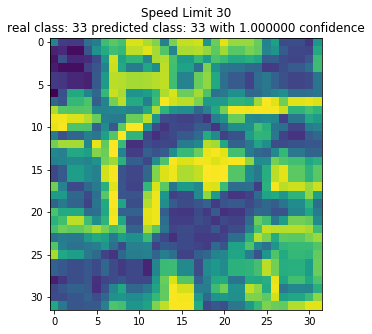

In [0]:
# Select an image to create adversarial samples
image_index = 3
image_array = images[image_index]
label = labels[image_index]
image = images_raw[image_index]
image = preprocess(image)

predicted_label = K.eval(pretrained_model(image))
lbl = np.where(predicted_label[0] == predicted_label[0].max())[0]
real_lbl = np.where(label == label.max())[0]
plt.title("Speed Limit 30\nreal class: %d predicted class: %d with %f confidence" % (real_lbl, lbl, predicted_label.max()))
plt.imshow(image_array.reshape((32,32)))
plt.show()

In [0]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

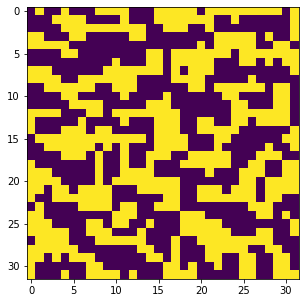

In [0]:
perturbations = create_adversarial_pattern(image, label)

sess = K.get_session()
array = sess.run(perturbations)

plt.imshow(array.reshape(32,32))
plt.show()

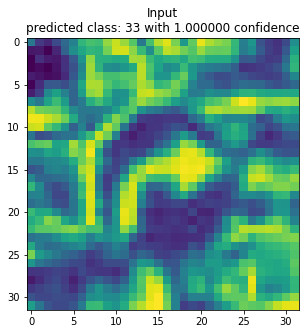

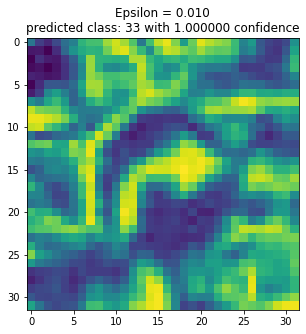

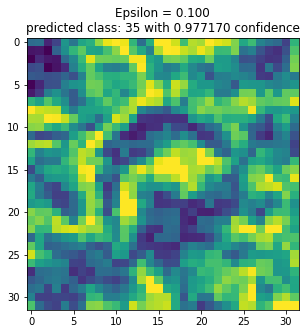

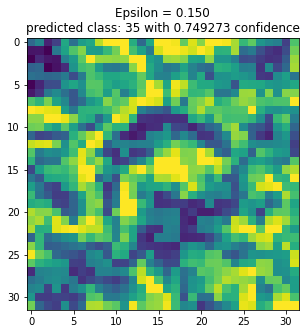

In [0]:
def display_images(image, description):
    label = pretrained_model(image)
    label = K.eval(label)
    lbl = np.where(label[0] == label[0].max())
    
    plt.figure()
    plt.title("%s\npredicted class: %d with %f confidence" % (description, lbl[0], label[0].max()))
    plt.imshow(K.eval(image[0]).reshape(32,32))
    plt.show()


epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
    adv_x = image + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, 0, 1)
    display_images(adv_x, descriptions[i])

In [0]:
def save_images(image, image_no, dir_name, real_label, real_predicted, real_predicted_conf):
    label = pretrained_model(image) # label of adversarial sample
    label = K.eval(label) # one hot encoded value of label
    lbl = np.where(label[0] == label[0].max()) # integer value of label

    # save image
    fig = plt.figure(frameon=False)
    fig.set_size_inches(128, 128)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(K.eval(image[0]).reshape(32,32))
    dpi = 1
    fig.savefig('adversarial/%s/%04d.jpg' % (dir_name, image_no), dpi=dpi)
    plt.close()
    
    
    # write to info.csv
    row = [('%04d.jpg' % image_no), real_label, # file_name, real label,
           real_predicted, real_predicted_conf, # real predicted, confidence,
           lbl[0], label[0].max()] # predicted adversarial label, confidence
                                                          
    with open('adversarial/%s/info.csv' % dir_name, 'a+') as f:
        writer = csv.writer(f)
        writer.writerow(row)


In [0]:
images2, labels2, images_raw2 = readTestTrafficSigns('/content/drive/My Drive/data', 500, True)

In [0]:
epsilons = [0.1]
dir_names = [('epsilon_{:d}'.format(int(eps*100))) for eps in epsilons]

In [0]:
for image_ind in range(len(images2)):
    image_array2 = images2[image_ind]
    label2 = labels2[image_ind]
    image2 = images_raw2[image_ind]
    image2 = preprocess(image2)
    
    predicted_label2 = K.eval(pretrained_model(image2))
    lbl2 = np.where(predicted_label2[0] == predicted_label2[0].max())[0]
    real_lbl2 = np.where(label2 == label2.max())[0]
    
    perturbations2 = create_adversarial_pattern(image2, label2)

    for i, eps in enumerate(epsilons):
        adv_x = image2 + eps*perturbations2
        adv_x = tf.clip_by_value(adv_x, 0, 1)
        save_images(adv_x, image_ind, dir_names[i], real_lbl2, lbl2, predicted_label2[0].max())
    print("image: %d is done" % image_ind)

In [0]:
from google.colab import files
for i in range(len(images2)):
  files.download('adversarial/epsilon_10/%04d.jpg' % i) 

In [0]:
!zip -r /content/epsilon_10.zip /content/adversarial/epsilon_10